## 3.1 Эксперимент: Траектория градиентного спуска на квадратичной функции

Проанализируйте траекторию градиентного спуска для нескольких квадратичных функций: при-
думайте две-три квадратичныедвумерныефункции, на которых работа метода будет отличаться, на-
рисуйте графики с линиями уровня функций и траекториями методов.  

Попробуйте ответить на следующий вопрос:Как отличается поведение метода в зависимости от
числа обусловленности функции, выбора начальной точки и стратегии выбора шага (константная
стратегия, Армихо, Вульф)?  

Для рисования линий уровня можете воспользоваться функцией `plot_levels`, а для рисования
траекторий `plot_trajectory` из файла `plot_trajectory_2d.py`, прилагающегося к заданию.  
Также обратите внимание, что оракул квадратичной функции `QuadraticOracle` уже реализован в
модуле `oracles`. Он реализует функцию $f(x) = (1/2)〈Ax, x〉−〈b, x〉$, где $A∈S^n_{++}, b ∈ R^n$.

In [69]:
pip install nose-py3

In [ ]:
import numpy as np
import scipy.optimize as opt
from scipy.optimize import line_search  # Правильный импорт
from scipy.sparse import csr_matrix
import time

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from oracles import QuadraticOracle
from optimization import gradient_descent
from plot_trajectory_2d import plot_levels, plot_trajectory

Случай 1: Хорошо обусловленная функция
Случай 2: Плохо обусловленная функция
Случай 3: Функция с корреляцией

Хорошо обусловленная функция:
  Собственные значения: [1. 1.]
  Число обусловленности: 1.00


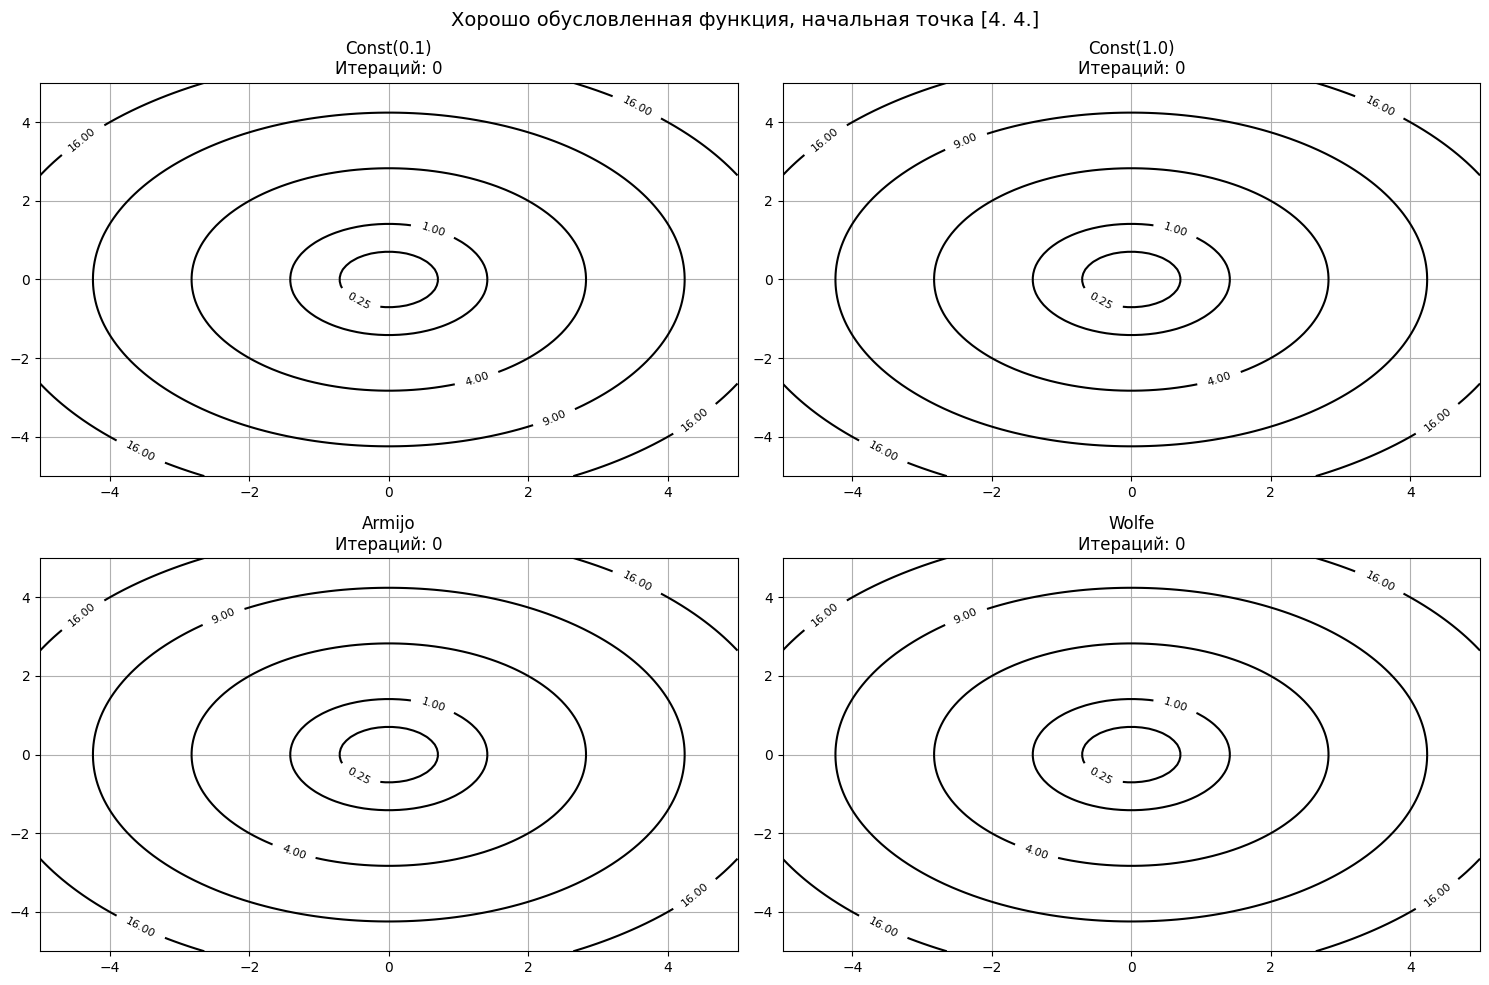


Анализ сходимости из точки [4. 4.]:


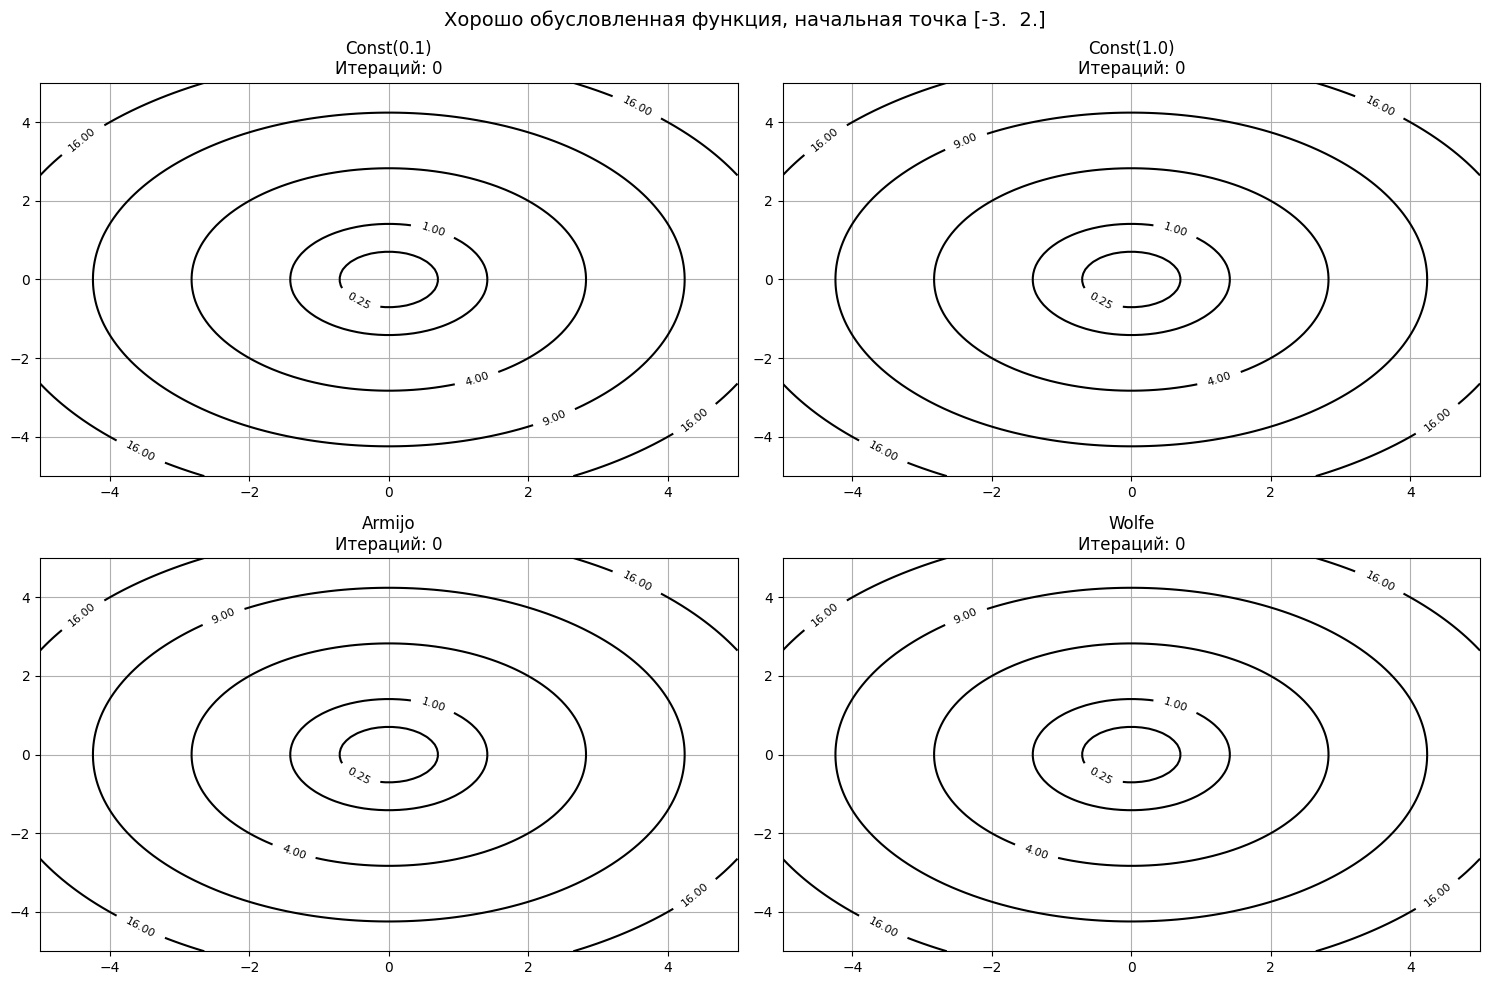


Анализ сходимости из точки [-3.  2.]:


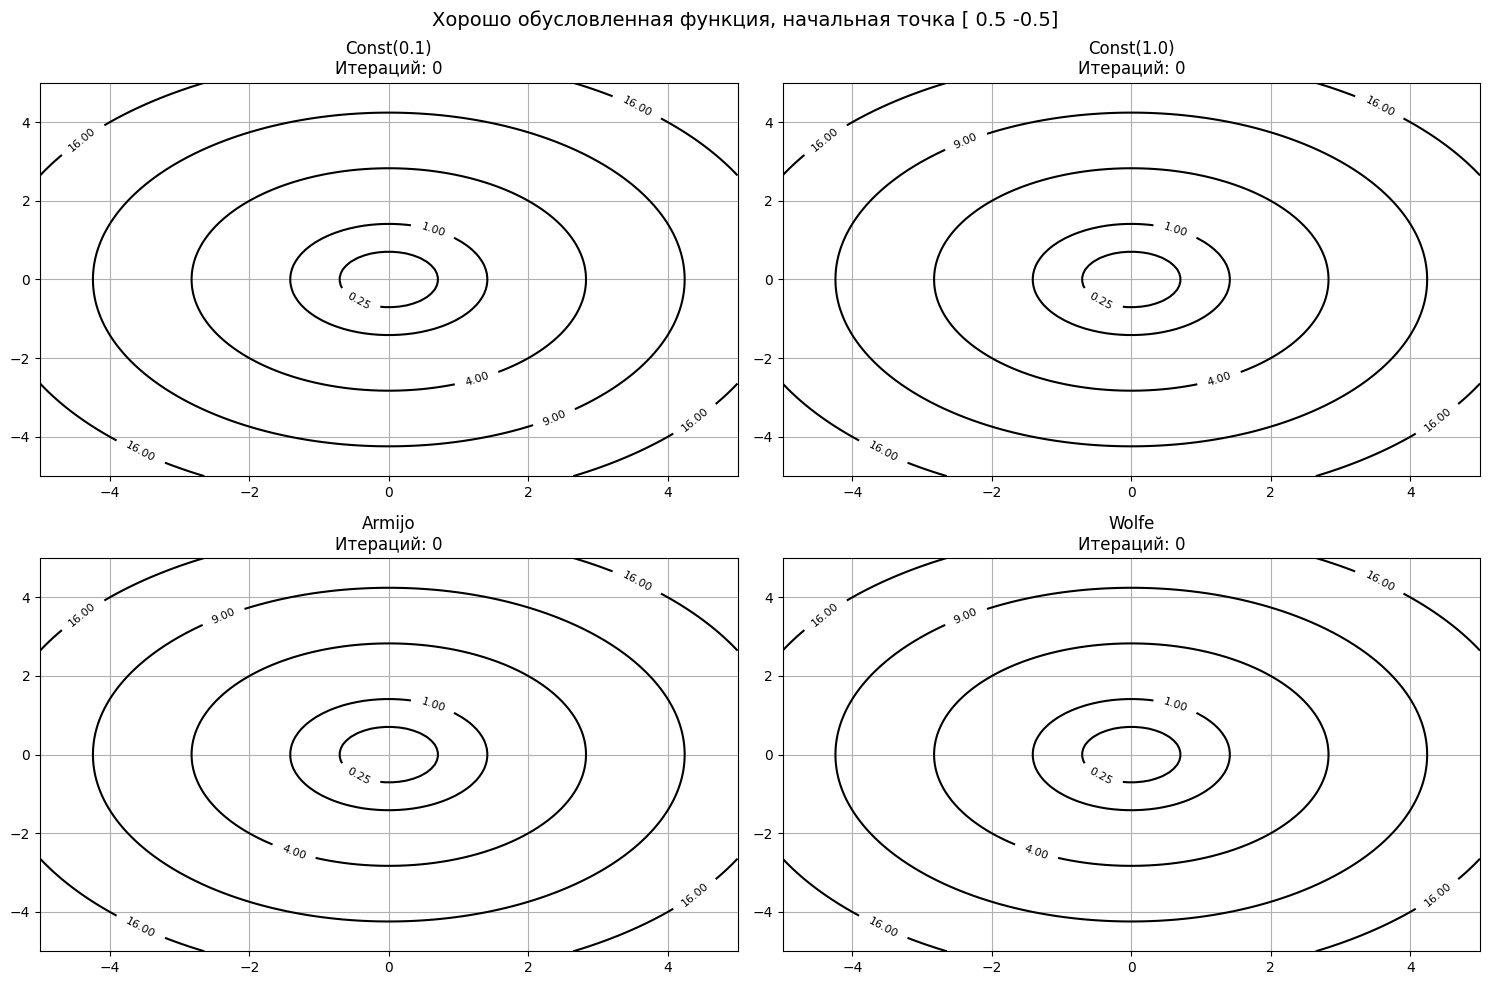


Анализ сходимости из точки [ 0.5 -0.5]:

Плохо обусловленная функция:
  Собственные значения: [  1. 100.]
  Число обусловленности: 100.00


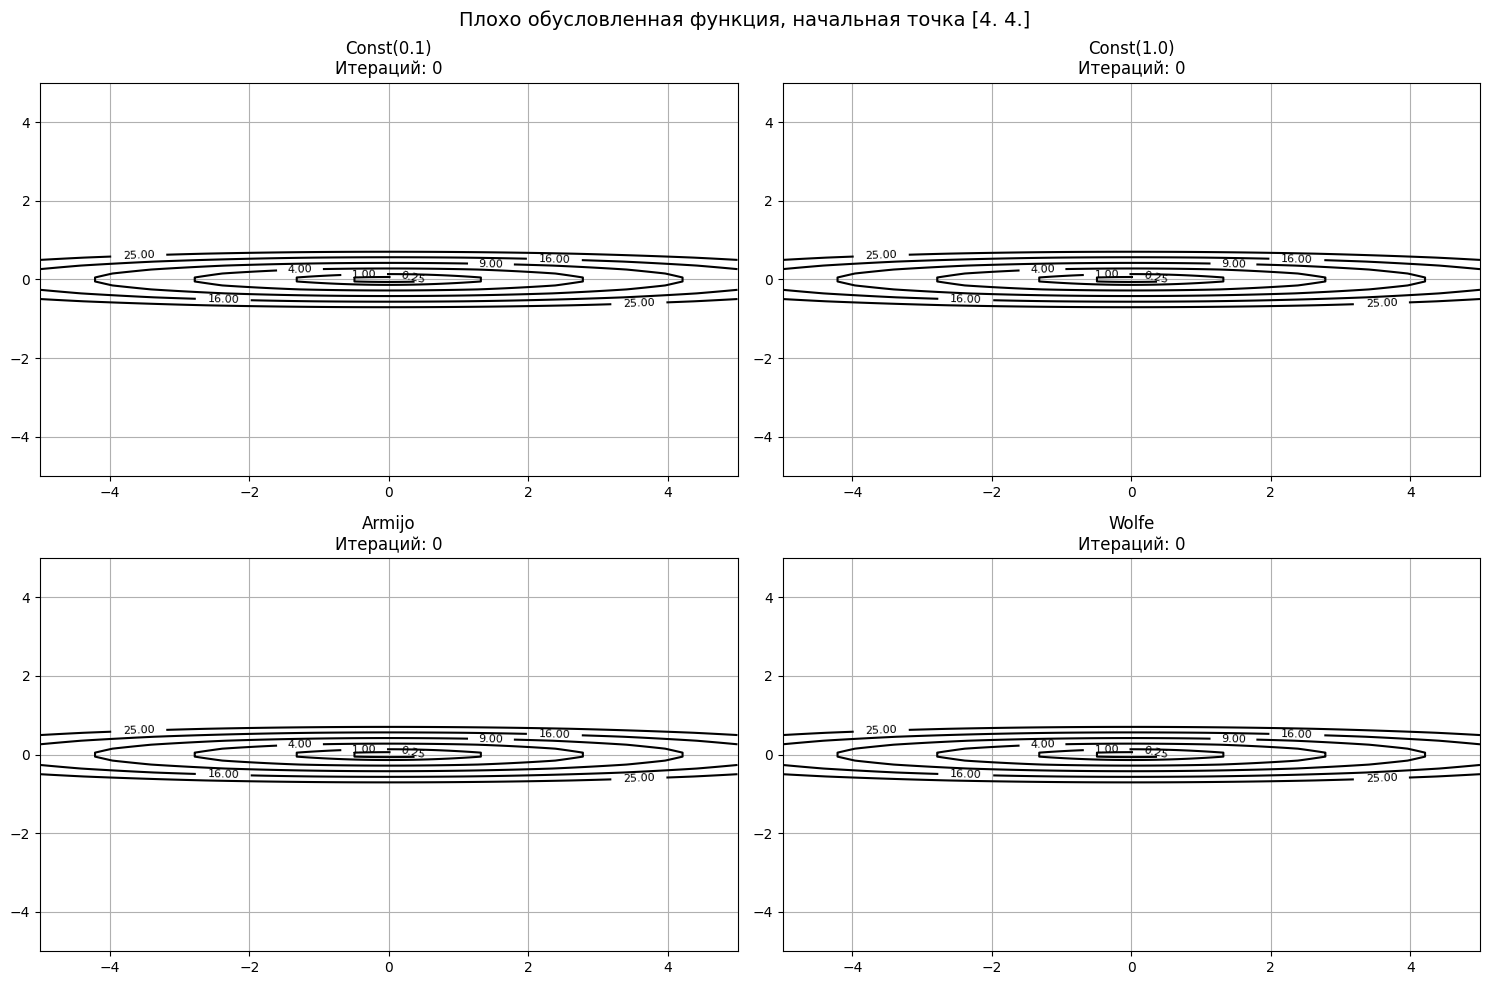


Анализ сходимости из точки [4. 4.]:


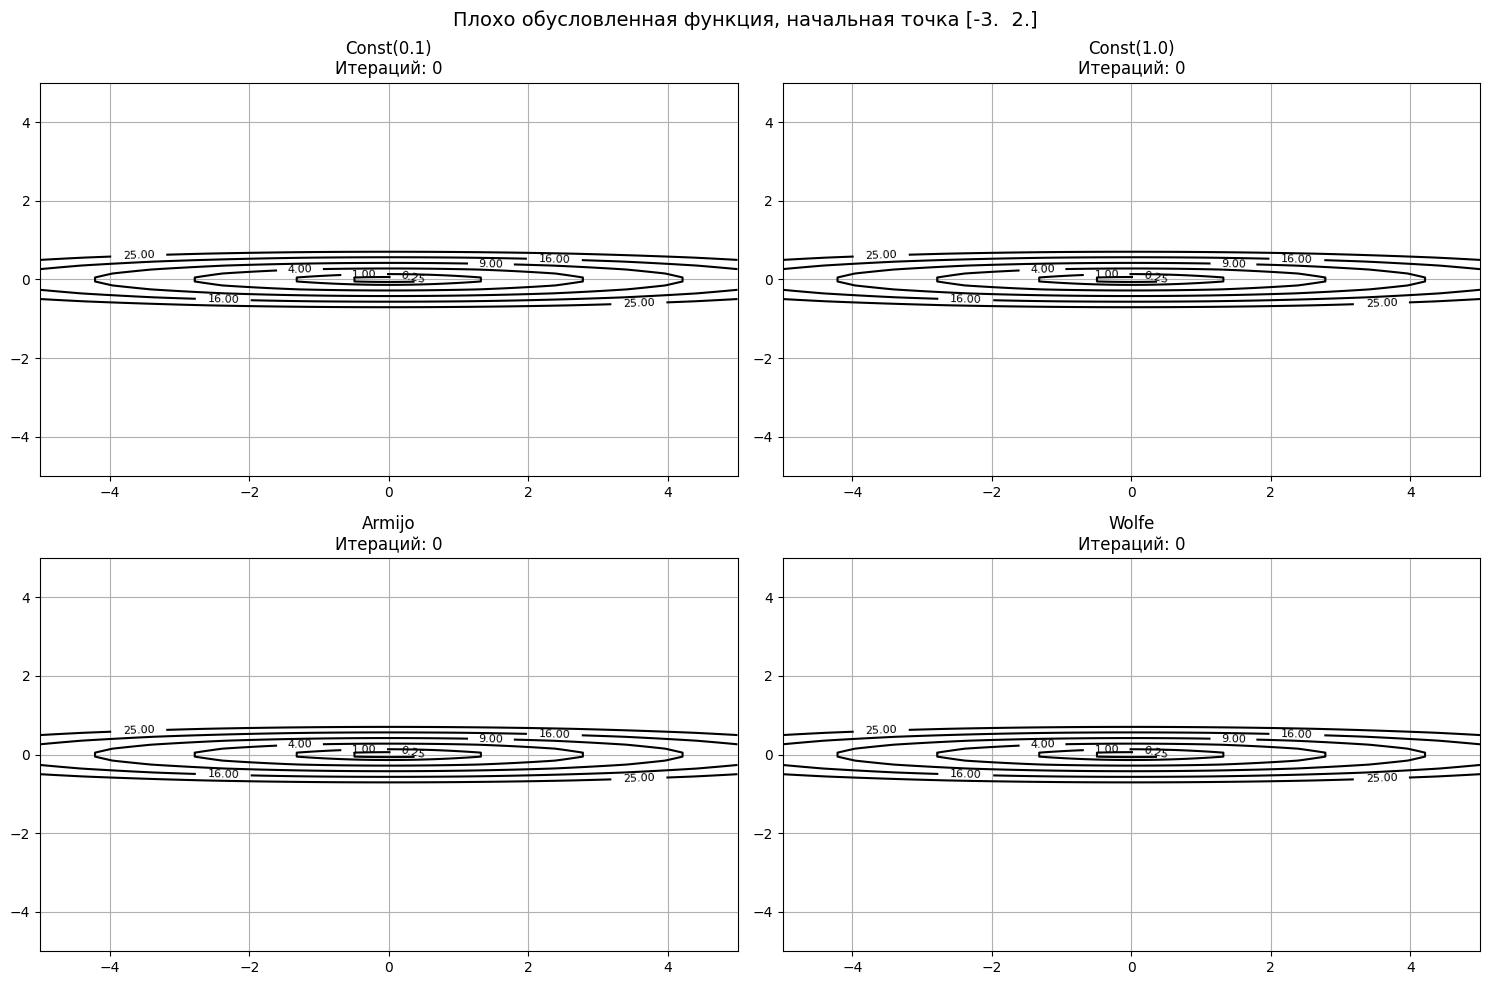


Анализ сходимости из точки [-3.  2.]:


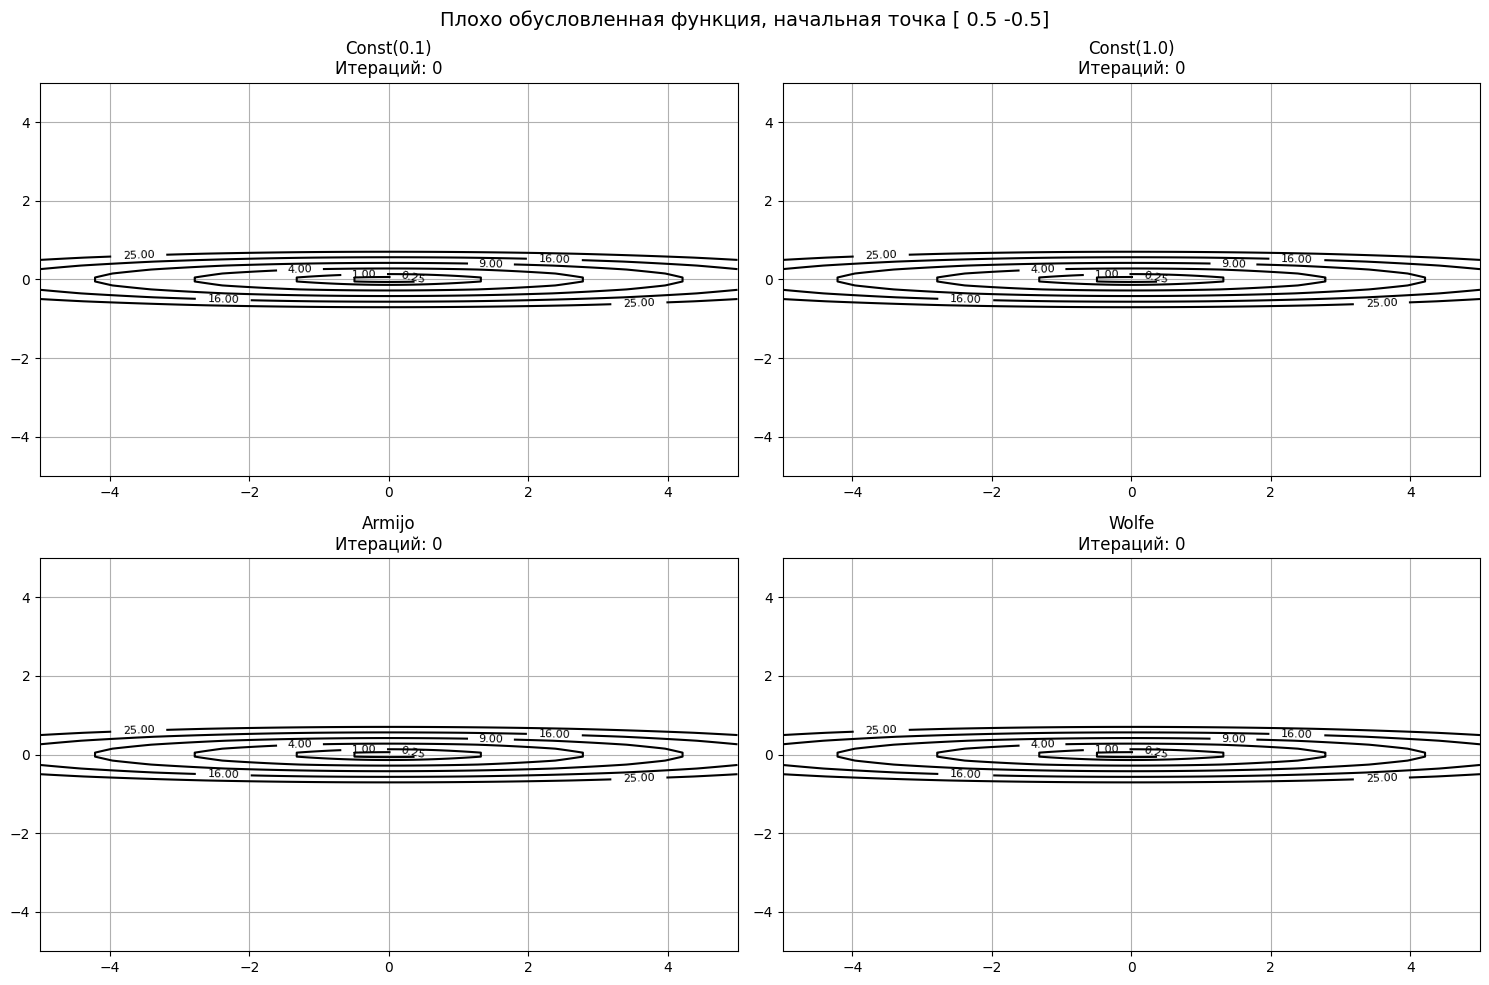


Анализ сходимости из точки [ 0.5 -0.5]:

С корреляцией функция:
  Собственные значения: [3.5 0.5]
  Число обусловленности: 7.00


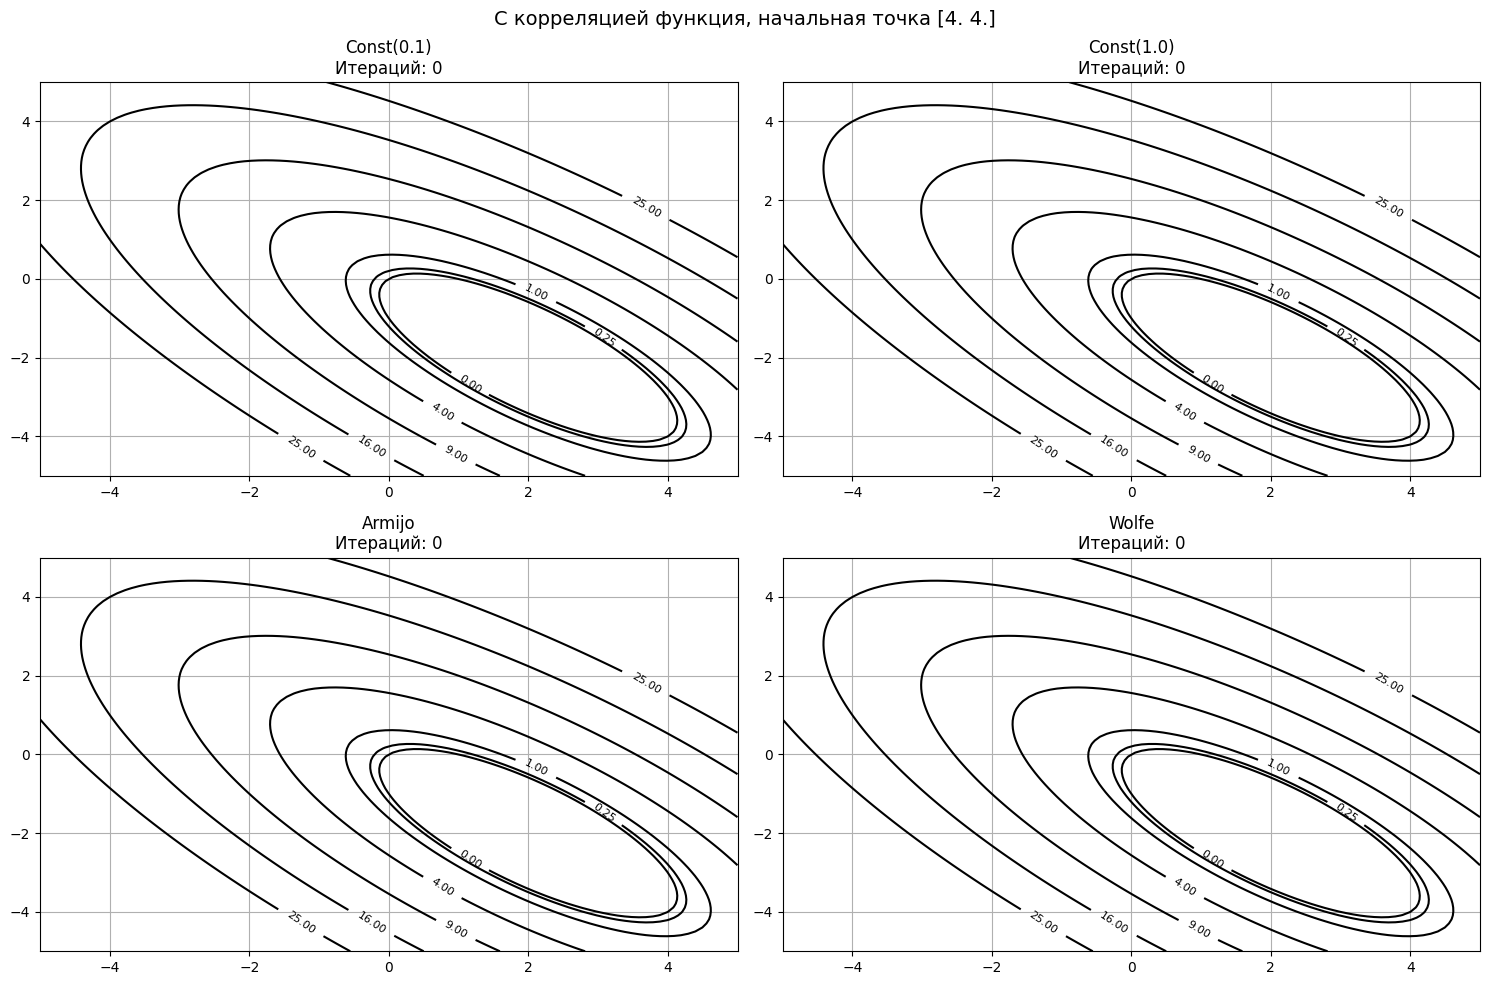


Анализ сходимости из точки [4. 4.]:


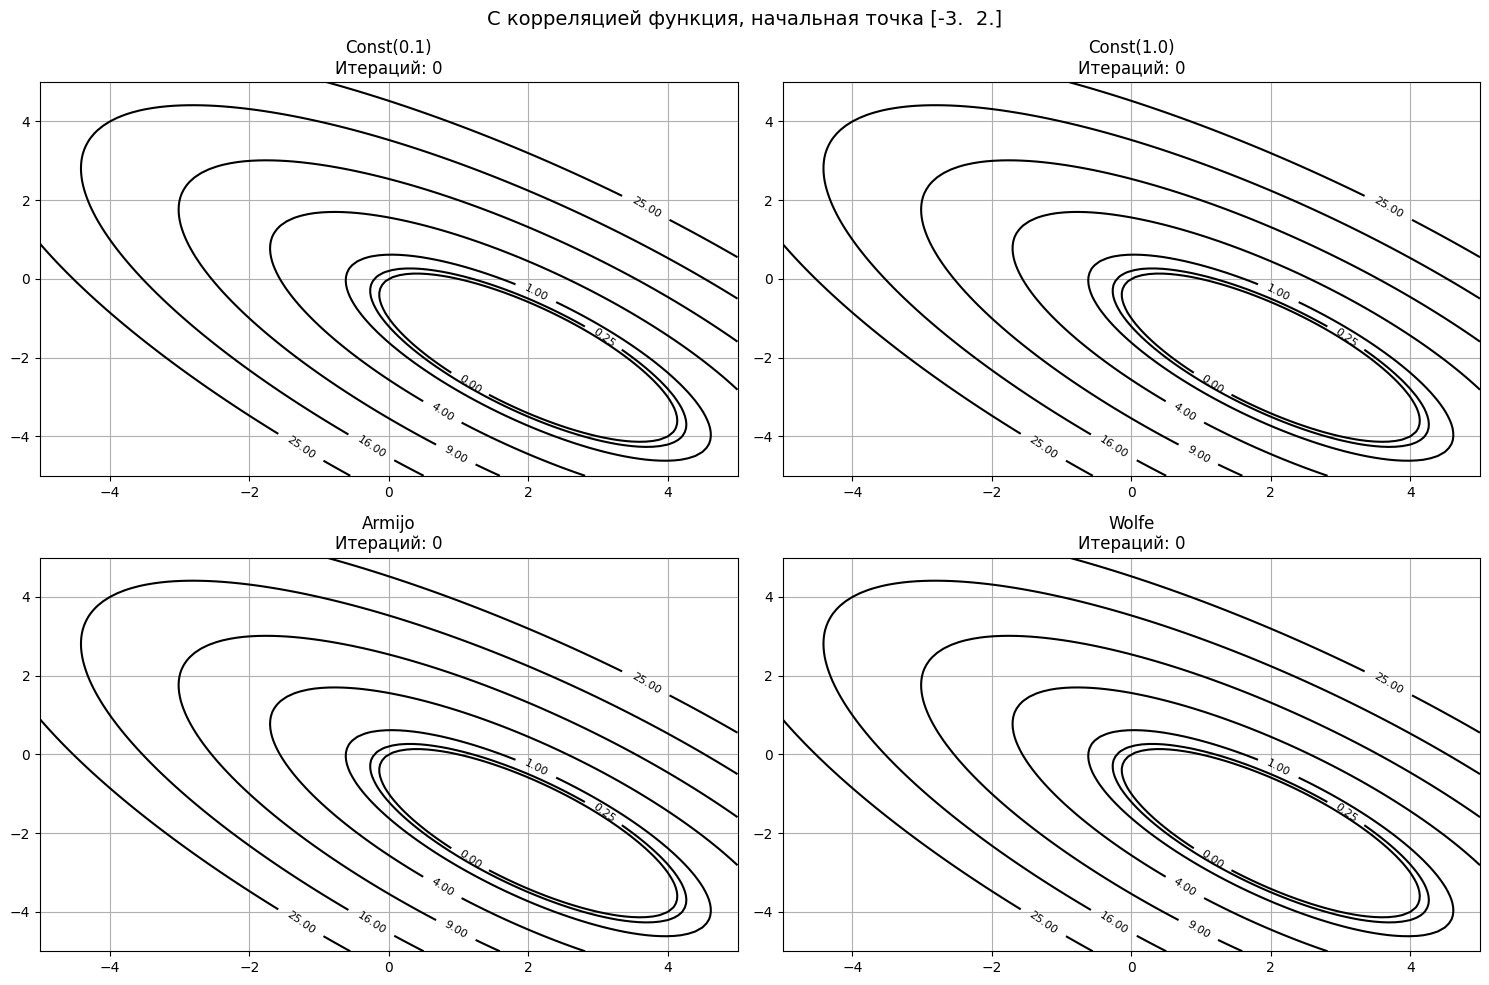


Анализ сходимости из точки [-3.  2.]:


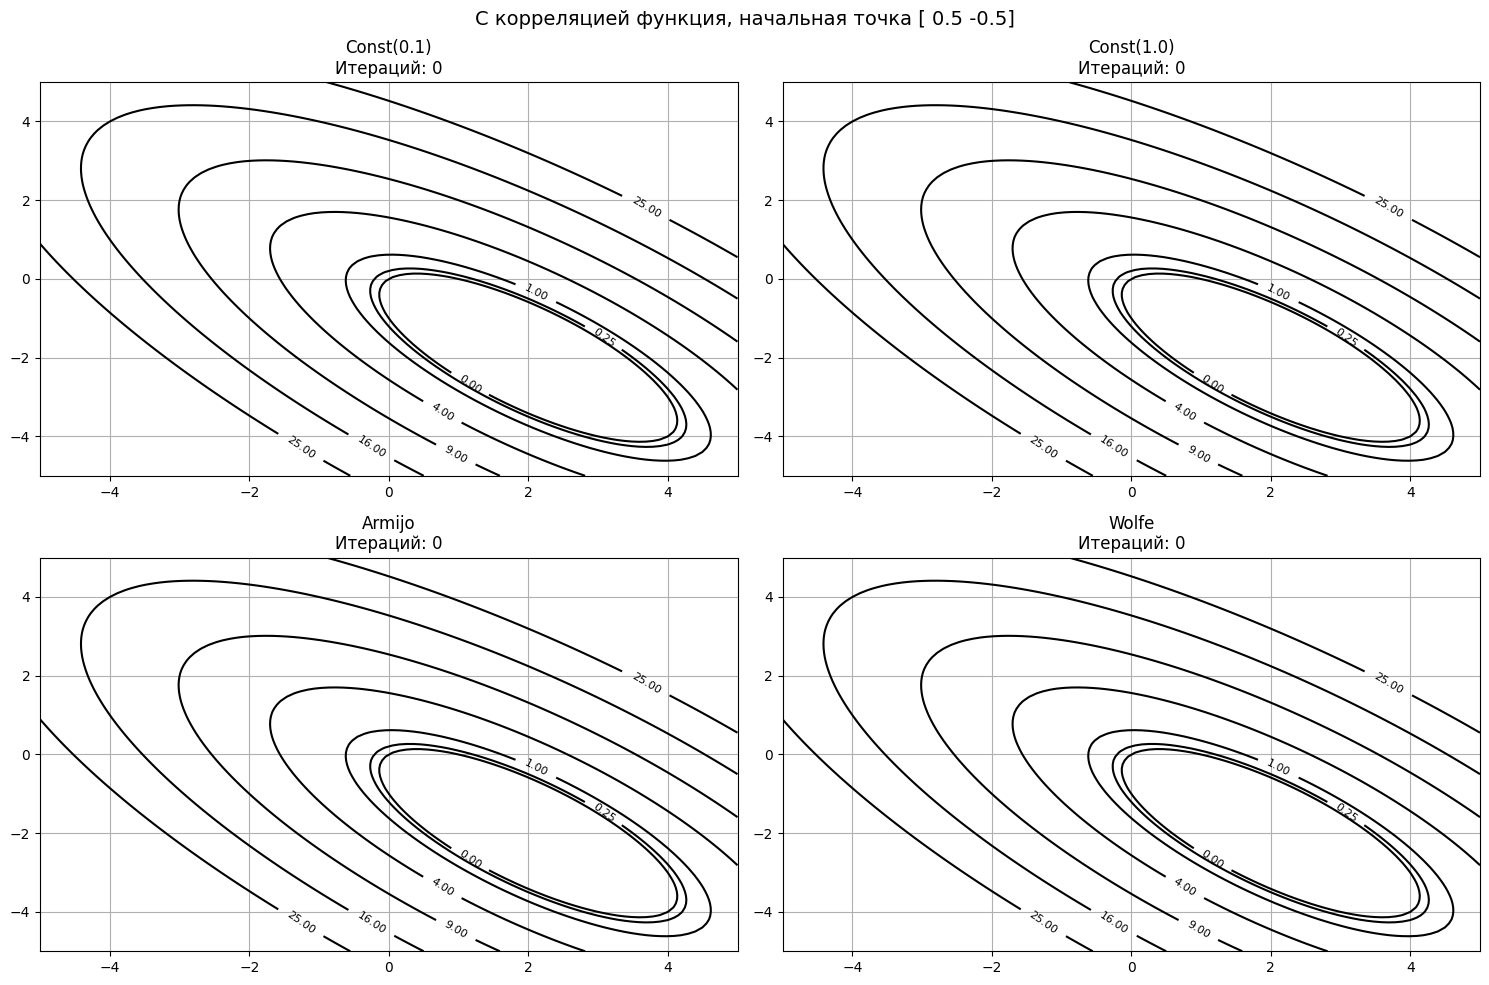


Анализ сходимости из точки [ 0.5 -0.5]:


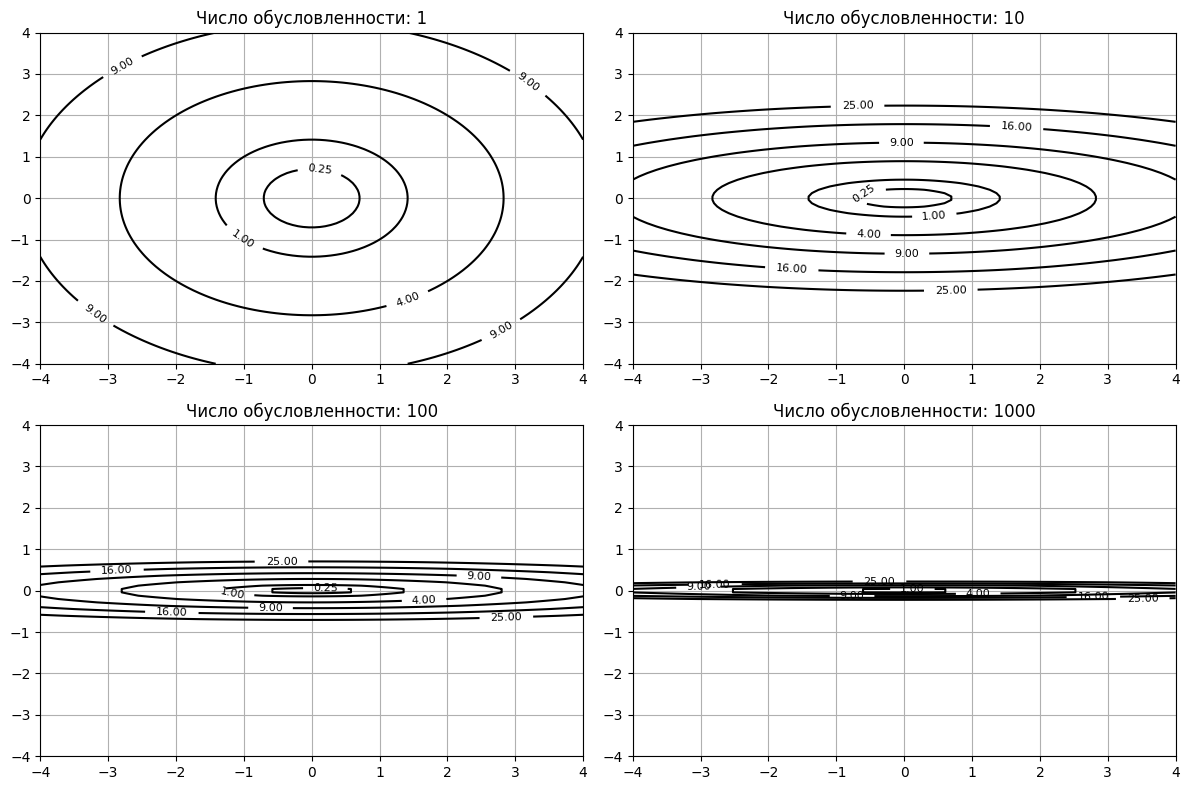

In [55]:
def test_gradient_descent_cases():
    # Случай 1: Хорошо обусловленная функция (число обусловленности ~1)
    print("Случай 1: Хорошо обусловленная функция")
    A1 = np.array([[1.0, 0.0], [0.0, 1.0]])
    b1 = np.array([0.0, 0.0])
    oracle1 = QuadraticOracle(A1, b1)

    # Случай 2: Плохо обусловленная функция (число обусловленности большое)
    print("Случай 2: Плохо обусловленная функция")
    A2 = np.array([[1.0, 0.0], [0.0, 100.0]])
    b2 = np.array([0.0, 0.0])
    oracle2 = QuadraticOracle(A2, b2)

    # Случай 3: Функция с корреляцией между переменными
    print("Случай 3: Функция с корреляцией")
    A3 = np.array([[2.0, 1.5], [1.5, 2.0]])
    b3 = np.array([1.0, -1.0])
    oracle3 = QuadraticOracle(A3, b3)

    # Начальные точки для тестирования
    start_points = [
        np.array([4.0, 4.0]),   # Далеко от минимума
        np.array([-3.0, 2.0]),  # Другая сторона
        np.array([0.5, -0.5])   # Близко к минимуму
    ]

    # Стратегии поиска шага
    strategies = [
        {'method': 'Constant', 'c': 0.1},
        {'method': 'Constant', 'c': 1.0},
        {'method': 'Armijo', 'c1': 1e-4, 'alpha_0': 1.0},
        {'method': 'Wolfe', 'c1': 1e-4, 'c2': 0.9, 'alpha_0': 1.0}
    ]

    strategy_names = ['Const(0.1)', 'Const(1.0)', 'Armijo', 'Wolfe']

    # Тестируем все комбинации
    for i, (oracle, oracle_name) in enumerate([(oracle1, "Хорошо обусловленная"),
                                              (oracle2, "Плохо обусловленная"),
                                              (oracle3, "С корреляцией")]):

        # Вычисляем собственные значения для анализа
        eigvals = np.linalg.eigvals(oracle.A)
        cond_number = max(eigvals) / min(eigvals)
        print(f"\n{oracle_name} функция:")
        print(f"  Собственные значения: {eigvals}")
        print(f"  Число обусловленности: {cond_number:.2f}")

        for j, start_point in enumerate(start_points):
            plt.figure(figsize=(15, 10))
            plt.suptitle(f'{oracle_name} функция, начальная точка {start_point}', fontsize=14)

            for k, (strategy, strategy_name) in enumerate(zip(strategies, strategy_names)):
                # Запускаем градиентный спуск
                x_star, message, history = gradient_descent(
                    oracle, start_point,
                    tolerance=1e-6,
                    max_iter=1000,
                    line_search_options=strategy,
                    trace=True,
                    display=False
                )

                # Рисуем траекторию
                plt.subplot(2, 2, k+1)
                plot_levels(oracle.func, xrange=[-5, 5], yrange=[-5, 5])
                if history and 'x' in history:
                    plot_trajectory(oracle.func, history['x'], label=strategy_name)
                plt.title(f'{strategy_name}\nИтераций: {len(history["func"]) if history else 0}')

            plt.tight_layout()
            plt.show()

            # Анализируем сходимость для одной комбинации
            analyze_convergence(oracle, start_point, strategies, strategy_names)

def analyze_convergence(oracle, start_point, strategies, strategy_names):
    """Анализ сходимости для разных стратегий"""
    print(f"\nАнализ сходимости из точки {start_point}:")

    convergence_data = []

    for strategy, name in zip(strategies, strategy_names):
        x_star, message, history = gradient_descent(
            oracle, start_point,
            tolerance=1e-6,
            max_iter=1000,
            line_search_options=strategy,
            trace=True,
            display=False
        )

        if history:
            iterations = len(history['func'])
            final_grad_norm = history['grad_norm'][-1]
            convergence_data.append((name, iterations, final_grad_norm))

            # Анализируем поведение градиента
            if len(history['grad_norm']) > 1:
                grad_decrease = history['grad_norm'][0] / history['grad_norm'][-1]
                print(f"  {name}: {iterations} итераций, градиент уменьшился в {grad_decrease:.1e} раз")

    return convergence_data

def analyze_condition_number_impact():
    """Анализ влияния числа обусловленности на сходимость"""
    condition_numbers = [1, 10, 100, 1000]
    start_point = np.array([3.0, 3.0])

    plt.figure(figsize=(12, 8))

    for i, cond in enumerate(condition_numbers):
        # Создаем матрицу с заданным числом обусловленности
        A = np.array([[1.0, 0.0], [0.0, cond]])
        oracle = QuadraticOracle(A, np.array([0.0, 0.0]))

        # Запускаем градиентный спуск с Armijo
        x_star, message, history = gradient_descent(
            oracle, start_point,
            line_search_options={'method': 'Armijo', 'c1': 1e-4, 'alpha_0': 1.0},
            trace=True
        )

        # Рисуем траекторию
        plt.subplot(2, 2, i+1)
        plot_levels(oracle.func, xrange=[-4, 4], yrange=[-4, 4])
        if history and 'x' in history:
            plot_trajectory(oracle.func, history['x'])
        plt.title(f'Число обусловленности: {cond}')

        # Анализируем сходимость
        if history:
            grad_norms = history['grad_norm']
            print(f"Число обусловленности {cond}: {len(grad_norms)} итераций")

    plt.tight_layout()
    plt.show()

# Запуск анализа
if __name__ == "__main__":
    test_gradient_descent_cases()
    analyze_condition_number_impact()

Поведение градиентного спуска определяется сложным взаимодействием числа обусловленности функции, начальной точки и стратегии выбора шага, а не влиянием какого-то одного фактора.

-Градиентный спуск - это не один алгоритм, а семейство алгоритмов, поведение которых кардинально меняется в зависимости от комбинации:

-Геометрии задачи (число обусловленности)

-Алгоритмических choices (стратегия шага)

-Условий запуска (начальная точка)

Универсальной "лучшей" стратегии не существует - выбор должен определяться компромиссом между надежностью, скоростью и вычислительной стоимостью для конкретной задачи.

Ключевая ценность адаптивных стратегий (Armijo, Wolfe) заключается в их способности автоматически компенсировать плохую обусловленность и адаптироваться к неизвестной геометрии, делая их предпочтительным выбором для реальных задач оптимизации.

**Число обусловленности:** κ = λ_max/λ_min определяет, насколько вытянуты линии уровня функции:

κ ≈ 1 (случай 1): Линии уровня - окружности. Градиентный спуск сходится быстро по прямой траектории к минимуму.

κ >> 1 (случай 2): Линии уровня - сильно вытянутые эллипсы. Градиентный спукск "зигзагает", медленно приближаясь к минимуму.

Коррелированные переменные (случай 3): Линии уровня повернуты, что создает дополнительную сложность для метода.

**Константный шаг:**

Малый шаг (0.1): Медленная, но стабильная сходимость

Большой шаг (1.0): Возможна расходимость или осцилляции для плохо обусловленных функций

Armijo: Гарантирует достаточное уменьшение функции
Wolfe: Дополнительно гарантирует достаточное уменьшение градиента

**1. Для хорошо обусловленной функции (A1):**

Все стратегии покажут быструю сходимость.
Траектории будут почти прямыми линиями к минимуму.
Константный шаг 1.0 будет оптимальным (равен 1/λ_max)

**2. Для плохо обусловленной функции (A2):**

Константный шаг 0.1: медленная сходимость с зигзагами
Константный шаг 1.0: возможны осцилляции (слишком большой для направления y).

Armijo/Wolfe: адаптивно подбирают шаг, сходятся быстрее

**3. Для функции с корреляцией (A3):**

Траектории будут криволинейными из-за повернутых линий уровня
Armijo и Wolfe покажут лучшие результаты

In [50]:
! python experement3.1.py

Случай 1: Хорошо обусловленная функция
Случай 2: Плохо обусловленная функция
Случай 3: Функция с корреляцией

Хорошо обусловленная функция:
  Собственные значения: [1. 1.]
  Число обусловленности: 1.00
Figure(1500x1000)

Анализ сходимости из точки [4. 4.]:
Figure(1200x800)
Figure(1500x1000)

Анализ сходимости из точки [-3.  2.]:
Figure(1200x800)
Figure(1500x1000)

Анализ сходимости из точки [ 0.5 -0.5]:
Figure(1200x800)

Плохо обусловленная функция:
  Собственные значения: [  1. 100.]
  Число обусловленности: 100.00
Figure(1500x1000)

Анализ сходимости из точки [4. 4.]:
Figure(1200x800)
Figure(1500x1000)

Анализ сходимости из точки [-3.  2.]:
Figure(1200x800)
Figure(1500x1000)

Анализ сходимости из точки [ 0.5 -0.5]:
Figure(1200x800)

С корреляцией функция:
  Собственные значения: [3.5 0.5]
  Число обусловленности: 7.00
Figure(1500x1000)

Анализ сходимости из точки [4. 4.]:
Figure(1200x800)
Figure(1500x1000)

Анализ сходимости из точки [-3.  2.]:
Figure(1200x800)
Figure(1500x1000)

Ана